# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rst in regularization_strengths:
        svm_classifier = LinearSVM()
        svm_classifier.train(X_train_feats,y_train,lr,rst,num_iters = 1500, batch_size = 200, verbose = True)
        
        y_train_pred = svm_classifier.predict(X_train_feats)
        train_acc = np.sum(y_train_pred == y_train)/len(y_train)
        
        y_val_pred = svm_classifier.predict(X_val_feats)
        val_acc = np.sum(y_val_pred == y_val)/(len(y_val))
        results[(lr,rst)] = (train_acc,val_acc)
        
        if(val_acc > best_val):
            best_val = val_acc
            best_svm = svm_classifier
        


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 85.088289
iteration 100 / 1500: loss 83.592004
iteration 200 / 1500: loss 82.117003
iteration 300 / 1500: loss 80.669722
iteration 400 / 1500: loss 79.251917
iteration 500 / 1500: loss 77.872902
iteration 600 / 1500: loss 76.493912
iteration 700 / 1500: loss 75.152983
iteration 800 / 1500: loss 73.854249
iteration 900 / 1500: loss 72.552158
iteration 1000 / 1500: loss 71.293693
iteration 1100 / 1500: loss 70.079674
iteration 1200 / 1500: loss 68.871121
iteration 1300 / 1500: loss 67.671503
iteration 1400 / 1500: loss 66.519526
iteration 0 / 1500: loss 768.807827
iteration 100 / 1500: loss 631.010038
iteration 200 / 1500: loss 518.220443
iteration 300 / 1500: loss 425.865484
iteration 400 / 1500: loss 350.264773
iteration 500 / 1500: loss 288.375711
iteration 600 / 1500: loss 237.717862
iteration 700 / 1500: loss 196.237232
iteration 800 / 1500: loss 162.281029
iteration 900 / 1500: loss 134.484406
iteration 1000 / 1500: loss 111.729233
iteration 1100 / 1500: lo

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


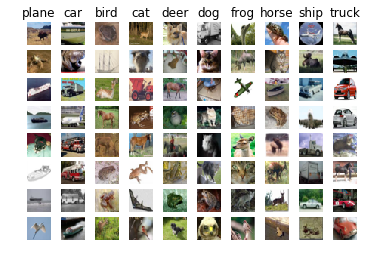

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

In [10]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [1e-5,1e-4,1e-3,5e-3,1e-2,1e-1,5e-1]
num_iters = [100,500,1000,2000,5000]
reg = [0.1,0.25,0.8,1.5,3,5,10]

results = {}
best_val = -1
for lr in learning_rates:
    for it in num_iters:
        for regu in reg:
            
            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=it, batch_size=200,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=regu, verbose=True)

            #Prediction on training set
            train_accuracy = (net.predict(X_train_feats) == y_train).mean()

            #Predict on validation set
            val_accuracy = (net.predict(X_val_feats) == y_val).mean()

            results[(lr,it,regu)] = (train_accuracy,val_accuracy)

            if(val_accuracy > best_val):
                best_val = val_accuracy
                best_net = net

for lr,it,regu in sorted(results):
    train_acc,val_acc = results[(lr,it,regu)]
    print('lr %e it %e regu %e train accuracy: %f val accuracy: %f' % (
                lr, it, regu, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross validation is: %f' %best_val)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 100: loss 2.302667
iteration 0 / 100: loss 2.302791
iteration 0 / 100: loss 2.303243
iteration 0 / 100: loss 2.303814
iteration 0 / 100: loss 2.305029
iteration 0 / 100: loss 2.306612
iteration 0 / 100: loss 2.310488
iteration 0 / 500: loss 2.302661
iteration 100 / 500: loss 2.302661
iteration 200 / 500: loss 2.302660
iteration 300 / 500: loss 2.302661
iteration 400 / 500: loss 2.302662
iteration 0 / 500: loss 2.302775
iteration 100 / 500: loss 2.302775
iteration 200 / 500: loss 2.302775
iteration 300 / 500: loss 2.302774
iteration 400 / 500: loss 2.302775
iteration 0 / 500: loss 2.303190
iteration 100 / 500: loss 2.303187
iteration 200 / 500: loss 2.303184
iteration 300 / 500: loss 2.303185
iteration 400 / 500: loss 2.303183
iteration 0 / 500: loss 2.303703
iteration 100 / 500: loss 2.303696
iteration 200 / 500: loss 2.303690
iteration 300 / 500: loss 2.303684
iteration 400 / 500: loss 2.303676
iteration 0 / 500: loss 2.304757
iteration 100 / 500: loss 2.304734
iteration

iteration 1700 / 2000: loss 2.303254
iteration 1800 / 2000: loss 2.303243
iteration 1900 / 2000: loss 2.303235
iteration 0 / 2000: loss 2.303856
iteration 100 / 2000: loss 2.303817
iteration 200 / 2000: loss 2.303761
iteration 300 / 2000: loss 2.303717
iteration 400 / 2000: loss 2.303688
iteration 500 / 2000: loss 2.303649
iteration 600 / 2000: loss 2.303600
iteration 700 / 2000: loss 2.303570
iteration 800 / 2000: loss 2.303540
iteration 900 / 2000: loss 2.303508
iteration 1000 / 2000: loss 2.303475
iteration 1100 / 2000: loss 2.303461
iteration 1200 / 2000: loss 2.303427
iteration 1300 / 2000: loss 2.303403
iteration 1400 / 2000: loss 2.303377
iteration 1500 / 2000: loss 2.303348
iteration 1600 / 2000: loss 2.303338
iteration 1700 / 2000: loss 2.303319
iteration 1800 / 2000: loss 2.303298
iteration 1900 / 2000: loss 2.303275
iteration 0 / 5000: loss 2.302593
iteration 100 / 5000: loss 2.302597
iteration 200 / 5000: loss 2.302598
iteration 300 / 5000: loss 2.302590
iteration 400 / 500

iteration 100 / 5000: loss 2.302733
iteration 200 / 5000: loss 2.302733
iteration 300 / 5000: loss 2.302733
iteration 400 / 5000: loss 2.302729
iteration 500 / 5000: loss 2.302717
iteration 600 / 5000: loss 2.302738
iteration 700 / 5000: loss 2.302732
iteration 800 / 5000: loss 2.302720
iteration 900 / 5000: loss 2.302723
iteration 1000 / 5000: loss 2.302717
iteration 1100 / 5000: loss 2.302726
iteration 1200 / 5000: loss 2.302696
iteration 1300 / 5000: loss 2.302718
iteration 1400 / 5000: loss 2.302701
iteration 1500 / 5000: loss 2.302698
iteration 1600 / 5000: loss 2.302714
iteration 1700 / 5000: loss 2.302708
iteration 1800 / 5000: loss 2.302712
iteration 1900 / 5000: loss 2.302694
iteration 2000 / 5000: loss 2.302713
iteration 2100 / 5000: loss 2.302697
iteration 2200 / 5000: loss 2.302693
iteration 2300 / 5000: loss 2.302699
iteration 2400 / 5000: loss 2.302695
iteration 2500 / 5000: loss 2.302701
iteration 2600 / 5000: loss 2.302701
iteration 2700 / 5000: loss 2.302695
iteration 

iteration 600 / 1000: loss 2.302582
iteration 700 / 1000: loss 2.302542
iteration 800 / 1000: loss 2.302594
iteration 900 / 1000: loss 2.302576
iteration 0 / 1000: loss 2.302582
iteration 100 / 1000: loss 2.302584
iteration 200 / 1000: loss 2.302563
iteration 300 / 1000: loss 2.302595
iteration 400 / 1000: loss 2.302557
iteration 500 / 1000: loss 2.302557
iteration 600 / 1000: loss 2.302618
iteration 700 / 1000: loss 2.302562
iteration 800 / 1000: loss 2.302568
iteration 900 / 1000: loss 2.302595
iteration 0 / 1000: loss 2.302587
iteration 100 / 1000: loss 2.302534
iteration 200 / 1000: loss 2.302592
iteration 300 / 1000: loss 2.302623
iteration 400 / 1000: loss 2.302586
iteration 500 / 1000: loss 2.302591
iteration 600 / 1000: loss 2.302537
iteration 700 / 1000: loss 2.302589
iteration 800 / 1000: loss 2.302607
iteration 900 / 1000: loss 2.302588
iteration 0 / 1000: loss 2.302597
iteration 100 / 1000: loss 2.302580
iteration 200 / 1000: loss 2.302563
iteration 300 / 1000: loss 2.30257

iteration 200 / 5000: loss 2.302496
iteration 300 / 5000: loss 2.302524
iteration 400 / 5000: loss 2.302583
iteration 500 / 5000: loss 2.302542
iteration 600 / 5000: loss 2.302463
iteration 700 / 5000: loss 2.302526
iteration 800 / 5000: loss 2.302465
iteration 900 / 5000: loss 2.302551
iteration 1000 / 5000: loss 2.302678
iteration 1100 / 5000: loss 2.302506
iteration 1200 / 5000: loss 2.302527
iteration 1300 / 5000: loss 2.302667
iteration 1400 / 5000: loss 2.302613
iteration 1500 / 5000: loss 2.302558
iteration 1600 / 5000: loss 2.302642
iteration 1700 / 5000: loss 2.302509
iteration 1800 / 5000: loss 2.302522
iteration 1900 / 5000: loss 2.302559
iteration 2000 / 5000: loss 2.302497
iteration 2100 / 5000: loss 2.302714
iteration 2200 / 5000: loss 2.302560
iteration 2300 / 5000: loss 2.302582
iteration 2400 / 5000: loss 2.302575
iteration 2500 / 5000: loss 2.302563
iteration 2600 / 5000: loss 2.302541
iteration 2700 / 5000: loss 2.302563
iteration 2800 / 5000: loss 2.302494
iteration

iteration 2500 / 5000: loss 2.302489
iteration 2600 / 5000: loss 2.302488
iteration 2700 / 5000: loss 2.302504
iteration 2800 / 5000: loss 2.302621
iteration 2900 / 5000: loss 2.302336
iteration 3000 / 5000: loss 2.302699
iteration 3100 / 5000: loss 2.302520
iteration 3200 / 5000: loss 2.302646
iteration 3300 / 5000: loss 2.302470
iteration 3400 / 5000: loss 2.302511
iteration 3500 / 5000: loss 2.302645
iteration 3600 / 5000: loss 2.302406
iteration 3700 / 5000: loss 2.302443
iteration 3800 / 5000: loss 2.302458
iteration 3900 / 5000: loss 2.302601
iteration 4000 / 5000: loss 2.302633
iteration 4100 / 5000: loss 2.302635
iteration 4200 / 5000: loss 2.302589
iteration 4300 / 5000: loss 2.302465
iteration 4400 / 5000: loss 2.302779
iteration 4500 / 5000: loss 2.302520
iteration 4600 / 5000: loss 2.302541
iteration 4700 / 5000: loss 2.302669
iteration 4800 / 5000: loss 2.302645
iteration 4900 / 5000: loss 2.302654
iteration 0 / 5000: loss 2.302507
iteration 100 / 5000: loss 2.302666
itera

iteration 100 / 2000: loss 2.303013
iteration 200 / 2000: loss 2.302564
iteration 300 / 2000: loss 2.302458
iteration 400 / 2000: loss 2.303017
iteration 500 / 2000: loss 2.302721
iteration 600 / 2000: loss 2.302481
iteration 700 / 2000: loss 2.302906
iteration 800 / 2000: loss 2.302858
iteration 900 / 2000: loss 2.302655
iteration 1000 / 2000: loss 2.302021
iteration 1100 / 2000: loss 2.302606
iteration 1200 / 2000: loss 2.303096
iteration 1300 / 2000: loss 2.302819
iteration 1400 / 2000: loss 2.302311
iteration 1500 / 2000: loss 2.302866
iteration 1600 / 2000: loss 2.302353
iteration 1700 / 2000: loss 2.302645
iteration 1800 / 2000: loss 2.302535
iteration 1900 / 2000: loss 2.302440
iteration 0 / 2000: loss 2.302600
iteration 100 / 2000: loss 2.302675
iteration 200 / 2000: loss 2.302484
iteration 300 / 2000: loss 2.302356
iteration 400 / 2000: loss 2.302558
iteration 500 / 2000: loss 2.302894
iteration 600 / 2000: loss 2.302442
iteration 700 / 2000: loss 2.302627
iteration 800 / 2000

iteration 2500 / 5000: loss 2.302382
iteration 2600 / 5000: loss 2.302572
iteration 2700 / 5000: loss 2.302581
iteration 2800 / 5000: loss 2.302603
iteration 2900 / 5000: loss 2.302630
iteration 3000 / 5000: loss 2.302548
iteration 3100 / 5000: loss 2.302534
iteration 3200 / 5000: loss 2.302361
iteration 3300 / 5000: loss 2.302500
iteration 3400 / 5000: loss 2.302343
iteration 3500 / 5000: loss 2.302860
iteration 3600 / 5000: loss 2.302752
iteration 3700 / 5000: loss 2.302338
iteration 3800 / 5000: loss 2.302476
iteration 3900 / 5000: loss 2.302761
iteration 4000 / 5000: loss 2.302556
iteration 4100 / 5000: loss 2.302506
iteration 4200 / 5000: loss 2.302305
iteration 4300 / 5000: loss 2.302241
iteration 4400 / 5000: loss 2.302513
iteration 4500 / 5000: loss 2.303207
iteration 4600 / 5000: loss 2.302855
iteration 4700 / 5000: loss 2.302312
iteration 4800 / 5000: loss 2.302522
iteration 4900 / 5000: loss 2.302522
iteration 0 / 5000: loss 2.302690
iteration 100 / 5000: loss 2.302868
itera

iteration 4800 / 5000: loss 2.302796
iteration 4900 / 5000: loss 2.302341
iteration 0 / 100: loss 2.303434
iteration 0 / 100: loss 2.302915
iteration 0 / 100: loss 2.303008
iteration 0 / 100: loss 2.302405
iteration 0 / 100: loss 2.302577
iteration 0 / 100: loss 2.302057
iteration 0 / 100: loss 2.302942
iteration 0 / 500: loss 2.302512
iteration 100 / 500: loss 2.302978
iteration 200 / 500: loss 2.302267
iteration 300 / 500: loss 2.302433
iteration 400 / 500: loss 2.302588
iteration 0 / 500: loss 2.302616
iteration 100 / 500: loss 2.302010
iteration 200 / 500: loss 2.302697
iteration 300 / 500: loss 2.302417
iteration 400 / 500: loss 2.302440
iteration 0 / 500: loss 2.302608
iteration 100 / 500: loss 2.302405
iteration 200 / 500: loss 2.302724
iteration 300 / 500: loss 2.302512
iteration 400 / 500: loss 2.302670
iteration 0 / 500: loss 2.302657
iteration 100 / 500: loss 2.302360
iteration 200 / 500: loss 2.302630
iteration 300 / 500: loss 2.302721
iteration 400 / 500: loss 2.302404
ite

iteration 1500 / 2000: loss 2.302081
iteration 1600 / 2000: loss 2.302313
iteration 1700 / 2000: loss 2.302178
iteration 1800 / 2000: loss 2.302766
iteration 1900 / 2000: loss 2.302495
iteration 0 / 2000: loss 2.302760
iteration 100 / 2000: loss 2.302520
iteration 200 / 2000: loss 2.302522
iteration 300 / 2000: loss 2.302631
iteration 400 / 2000: loss 2.302903
iteration 500 / 2000: loss 2.302430
iteration 600 / 2000: loss 2.302291
iteration 700 / 2000: loss 2.302905
iteration 800 / 2000: loss 2.302491
iteration 900 / 2000: loss 2.302667
iteration 1000 / 2000: loss 2.302378
iteration 1100 / 2000: loss 2.302514
iteration 1200 / 2000: loss 2.302732
iteration 1300 / 2000: loss 2.302589
iteration 1400 / 2000: loss 2.302565
iteration 1500 / 2000: loss 2.302420
iteration 1600 / 2000: loss 2.302614
iteration 1700 / 2000: loss 2.302581
iteration 1800 / 2000: loss 2.302907
iteration 1900 / 2000: loss 2.302727
iteration 0 / 5000: loss 2.302414
iteration 100 / 5000: loss 2.302372
iteration 200 / 5

iteration 4900 / 5000: loss 2.303085
iteration 0 / 5000: loss 2.302331
iteration 100 / 5000: loss 2.302794
iteration 200 / 5000: loss 2.301964
iteration 300 / 5000: loss 2.302679
iteration 400 / 5000: loss 2.302494
iteration 500 / 5000: loss 2.302574
iteration 600 / 5000: loss 2.302608
iteration 700 / 5000: loss 2.303080
iteration 800 / 5000: loss 2.302691
iteration 900 / 5000: loss 2.302999
iteration 1000 / 5000: loss 2.302234
iteration 1100 / 5000: loss 2.302405
iteration 1200 / 5000: loss 2.302589
iteration 1300 / 5000: loss 2.301977
iteration 1400 / 5000: loss 2.302949
iteration 1500 / 5000: loss 2.302396
iteration 1600 / 5000: loss 2.302605
iteration 1700 / 5000: loss 2.302389
iteration 1800 / 5000: loss 2.302728
iteration 1900 / 5000: loss 2.302809
iteration 2000 / 5000: loss 2.302598
iteration 2100 / 5000: loss 2.302515
iteration 2200 / 5000: loss 2.302629
iteration 2300 / 5000: loss 2.302377
iteration 2400 / 5000: loss 2.302720
iteration 2500 / 5000: loss 2.302593
iteration 260

iteration 400 / 1000: loss 2.302856
iteration 500 / 1000: loss 2.302718
iteration 600 / 1000: loss 2.302614
iteration 700 / 1000: loss 2.302568
iteration 800 / 1000: loss 2.302347
iteration 900 / 1000: loss 2.302720
iteration 0 / 1000: loss 2.302496
iteration 100 / 1000: loss 2.302442
iteration 200 / 1000: loss 2.302278
iteration 300 / 1000: loss 2.302625
iteration 400 / 1000: loss 2.302435
iteration 500 / 1000: loss 2.303291
iteration 600 / 1000: loss 2.302313
iteration 700 / 1000: loss 2.302718
iteration 800 / 1000: loss 2.302777
iteration 900 / 1000: loss 2.301630
iteration 0 / 1000: loss 2.301882
iteration 100 / 1000: loss 2.301841
iteration 200 / 1000: loss 2.303106
iteration 300 / 1000: loss 2.302382
iteration 400 / 1000: loss 2.302994
iteration 500 / 1000: loss 2.302425
iteration 600 / 1000: loss 2.302781
iteration 700 / 1000: loss 2.302878
iteration 800 / 1000: loss 2.302320
iteration 900 / 1000: loss 2.303020
iteration 0 / 1000: loss 2.302498
iteration 100 / 1000: loss 2.30299

iteration 0 / 5000: loss 2.302340
iteration 100 / 5000: loss 2.302493
iteration 200 / 5000: loss 2.302764
iteration 300 / 5000: loss 2.302616
iteration 400 / 5000: loss 2.302518
iteration 500 / 5000: loss 2.302433
iteration 600 / 5000: loss 2.302606
iteration 700 / 5000: loss 2.302551
iteration 800 / 5000: loss 2.302487
iteration 900 / 5000: loss 2.302641
iteration 1000 / 5000: loss 2.302994
iteration 1100 / 5000: loss 2.302630
iteration 1200 / 5000: loss 2.302633
iteration 1300 / 5000: loss 2.302967
iteration 1400 / 5000: loss 2.302264
iteration 1500 / 5000: loss 2.302554
iteration 1600 / 5000: loss 2.302513
iteration 1700 / 5000: loss 2.302572
iteration 1800 / 5000: loss 2.303010
iteration 1900 / 5000: loss 2.302855
iteration 2000 / 5000: loss 2.302388
iteration 2100 / 5000: loss 2.302333
iteration 2200 / 5000: loss 2.302580
iteration 2300 / 5000: loss 2.302406
iteration 2400 / 5000: loss 2.302607
iteration 2500 / 5000: loss 2.302833
iteration 2600 / 5000: loss 2.302456
iteration 270

iteration 2400 / 5000: loss 2.302512
iteration 2500 / 5000: loss 2.302524
iteration 2600 / 5000: loss 2.302607
iteration 2700 / 5000: loss 2.302347
iteration 2800 / 5000: loss 2.302169
iteration 2900 / 5000: loss 2.302820
iteration 3000 / 5000: loss 2.303109
iteration 3100 / 5000: loss 2.302870
iteration 3200 / 5000: loss 2.302421
iteration 3300 / 5000: loss 2.302917
iteration 3400 / 5000: loss 2.302633
iteration 3500 / 5000: loss 2.303051
iteration 3600 / 5000: loss 2.302692
iteration 3700 / 5000: loss 2.302678
iteration 3800 / 5000: loss 2.302336
iteration 3900 / 5000: loss 2.302719
iteration 4000 / 5000: loss 2.302725
iteration 4100 / 5000: loss 2.303042
iteration 4200 / 5000: loss 2.302836
iteration 4300 / 5000: loss 2.302481
iteration 4400 / 5000: loss 2.302555
iteration 4500 / 5000: loss 2.302879
iteration 4600 / 5000: loss 2.302858
iteration 4700 / 5000: loss 2.301977
iteration 4800 / 5000: loss 2.302751
iteration 4900 / 5000: loss 2.302930
iteration 0 / 5000: loss 2.302688
iter

iteration 0 / 2000: loss 2.425556
iteration 100 / 2000: loss 2.316288
iteration 200 / 2000: loss 2.305424
iteration 300 / 2000: loss 2.307349
iteration 400 / 2000: loss 2.301763
iteration 500 / 2000: loss 2.304797
iteration 600 / 2000: loss 2.303842
iteration 700 / 2000: loss 2.304790
iteration 800 / 2000: loss 2.307898
iteration 900 / 2000: loss 2.303406
iteration 1000 / 2000: loss 2.299557
iteration 1100 / 2000: loss 2.304390
iteration 1200 / 2000: loss 2.303911
iteration 1300 / 2000: loss 2.303232
iteration 1400 / 2000: loss 2.302220
iteration 1500 / 2000: loss 2.300842
iteration 1600 / 2000: loss 2.304004
iteration 1700 / 2000: loss 2.302868
iteration 1800 / 2000: loss 2.301239
iteration 1900 / 2000: loss 2.305153
iteration 0 / 2000: loss 2.307724
iteration 100 / 2000: loss 2.300594
iteration 200 / 2000: loss 2.302023
iteration 300 / 2000: loss 2.305113
iteration 400 / 2000: loss 2.299154
iteration 500 / 2000: loss 2.305158
iteration 600 / 2000: loss 2.303163
iteration 700 / 2000: 

iteration 2500 / 5000: loss 2.307121
iteration 2600 / 5000: loss 2.300483
iteration 2700 / 5000: loss 2.308387
iteration 2800 / 5000: loss 2.306486
iteration 2900 / 5000: loss 2.304705
iteration 3000 / 5000: loss 2.304951
iteration 3100 / 5000: loss 2.301834
iteration 3200 / 5000: loss 2.301140
iteration 3300 / 5000: loss 2.302536
iteration 3400 / 5000: loss 2.298159
iteration 3500 / 5000: loss 2.301522
iteration 3600 / 5000: loss 2.300841
iteration 3700 / 5000: loss 2.303395
iteration 3800 / 5000: loss 2.304614
iteration 3900 / 5000: loss 2.309087
iteration 4000 / 5000: loss 2.302867
iteration 4100 / 5000: loss 2.304234
iteration 4200 / 5000: loss 2.303642
iteration 4300 / 5000: loss 2.305048
iteration 4400 / 5000: loss 2.304443
iteration 4500 / 5000: loss 2.306779
iteration 4600 / 5000: loss 2.302965
iteration 4700 / 5000: loss 2.304277
iteration 4800 / 5000: loss 2.304036
iteration 4900 / 5000: loss 2.301590
iteration 0 / 5000: loss 2.302160
iteration 100 / 5000: loss 2.311107
itera

iteration 4800 / 5000: loss 2.303028
iteration 4900 / 5000: loss 2.303561
iteration 0 / 100: loss 2.302778
iteration 0 / 100: loss 2.409456
iteration 0 / 100: loss 2.396766
iteration 0 / 100: loss 2.310206
iteration 0 / 100: loss 2.326662


/home/siddharth/Documents/assignment1/cs231n/classifiers/neural_net.py:106: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(real_scores/scores_sum))
/home/siddharth/Documents/assignment1/cs231n/classifiers/neural_net.py:106: RuntimeWarning: invalid value encountered in true_divide
  loss = np.sum(-np.log(real_scores/scores_sum))
/home/siddharth/Documents/assignment1/cs231n/classifiers/neural_net.py:123: RuntimeWarning: invalid value encountered in true_divide
  grads_w2 = (exp_scores.T/scores_sum).T
/home/siddharth/Documents/assignment1/cs231n/classifiers/neural_net.py:124: RuntimeWarning: invalid value encountered in true_divide
  grads_w2[np.arange(N),y] = -(1 - (exp_scores[np.arange(N),y]/scores_sum))


iteration 0 / 100: loss nan
iteration 0 / 100: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss nan
iteration 200 / 500: loss nan
iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss nan
iteration 200 / 500: loss nan
iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss nan
iteration 200 / 500: loss nan
iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss nan
iteration 200 / 500: loss nan
iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss nan
iteration 200 / 500: loss nan
iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss nan
iteration 200 / 500: loss nan
iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
iteration 0 / 500: loss nan
iteration 100 / 500: loss na

iteration 1800 / 5000: loss nan
iteration 1900 / 5000: loss nan
iteration 2000 / 5000: loss nan
iteration 2100 / 5000: loss nan
iteration 2200 / 5000: loss nan
iteration 2300 / 5000: loss nan
iteration 2400 / 5000: loss nan
iteration 2500 / 5000: loss nan
iteration 2600 / 5000: loss nan
iteration 2700 / 5000: loss nan
iteration 2800 / 5000: loss nan
iteration 2900 / 5000: loss nan
iteration 3000 / 5000: loss nan
iteration 3100 / 5000: loss nan
iteration 3200 / 5000: loss nan
iteration 3300 / 5000: loss nan
iteration 3400 / 5000: loss nan
iteration 3500 / 5000: loss nan
iteration 3600 / 5000: loss nan
iteration 3700 / 5000: loss nan
iteration 3800 / 5000: loss nan
iteration 3900 / 5000: loss nan
iteration 4000 / 5000: loss nan
iteration 4100 / 5000: loss nan
iteration 4200 / 5000: loss nan
iteration 4300 / 5000: loss nan
iteration 4400 / 5000: loss nan
iteration 4500 / 5000: loss nan
iteration 4600 / 5000: loss nan
iteration 4700 / 5000: loss nan
iteration 4800 / 5000: loss nan
iteratio

iteration 2600 / 5000: loss nan
iteration 2700 / 5000: loss nan
iteration 2800 / 5000: loss nan
iteration 2900 / 5000: loss nan
iteration 3000 / 5000: loss nan
iteration 3100 / 5000: loss nan
iteration 3200 / 5000: loss nan
iteration 3300 / 5000: loss nan
iteration 3400 / 5000: loss nan
iteration 3500 / 5000: loss nan
iteration 3600 / 5000: loss nan
iteration 3700 / 5000: loss nan
iteration 3800 / 5000: loss nan
iteration 3900 / 5000: loss nan
iteration 4000 / 5000: loss nan
iteration 4100 / 5000: loss nan
iteration 4200 / 5000: loss nan
iteration 4300 / 5000: loss nan
iteration 4400 / 5000: loss nan
iteration 4500 / 5000: loss nan
iteration 4600 / 5000: loss nan
iteration 4700 / 5000: loss nan
iteration 4800 / 5000: loss nan
iteration 4900 / 5000: loss nan
iteration 0 / 5000: loss nan
iteration 100 / 5000: loss nan
iteration 200 / 5000: loss nan
iteration 300 / 5000: loss nan
iteration 400 / 5000: loss nan
iteration 500 / 5000: loss nan
iteration 600 / 5000: loss nan
iteration 700 / 5

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)